In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the necessary libraries
import os
import matplotlib.pyplot as plt
import cv2
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, callbacks, applications
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Loading & Initial Analysis

In [ ]:
# Set the dataset directory
dataset_path = '/content/drive/MyDrive/dental_dataset'

# Check folders (assuming folder per class)
print("Classes:")
for folder in os.listdir(dataset_path):
    print(f"- {folder}")

Classes:
- Hypodontia
- Ulcers
- Tooth_discoloration
- Healthy
- Calculus
- Caries
- Gingivitis


In [ ]:
# Check image counts per class
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    num_images = len(os.listdir(folder_path))
    print(f"{folder}: {num_images} images")

Hypodontia: 1251 images
Ulcers: 2540 images
Tooth_discoloration: 1822 images
Healthy: 2275 images
Calculus: 1296 images
Caries: 2411 images
Gingivitis: 2359 images


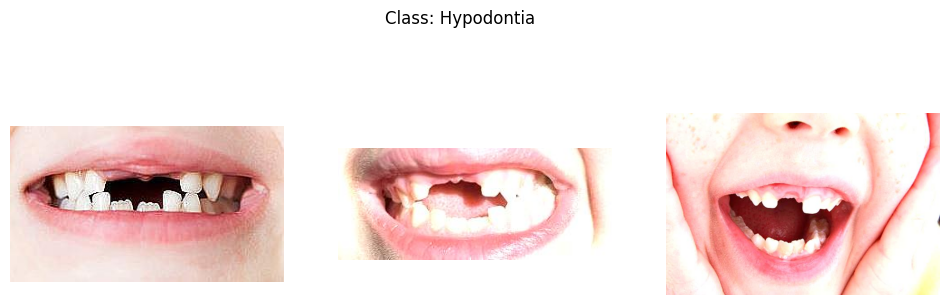

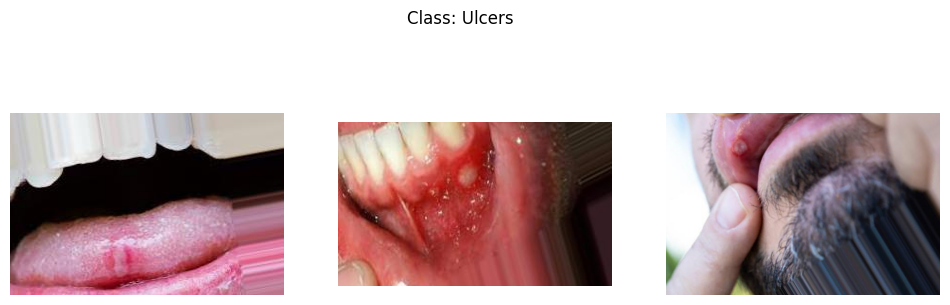

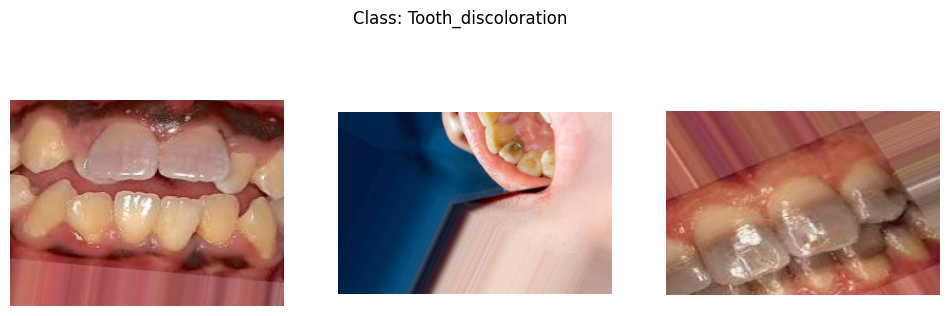

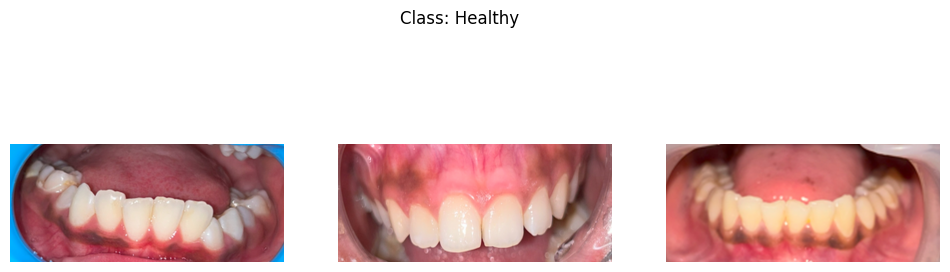

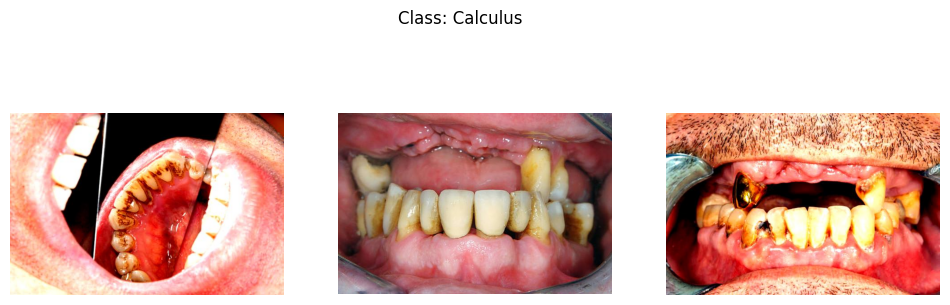

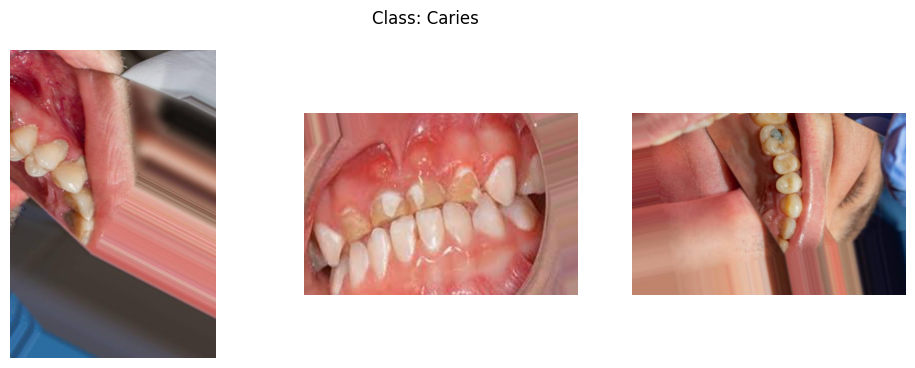

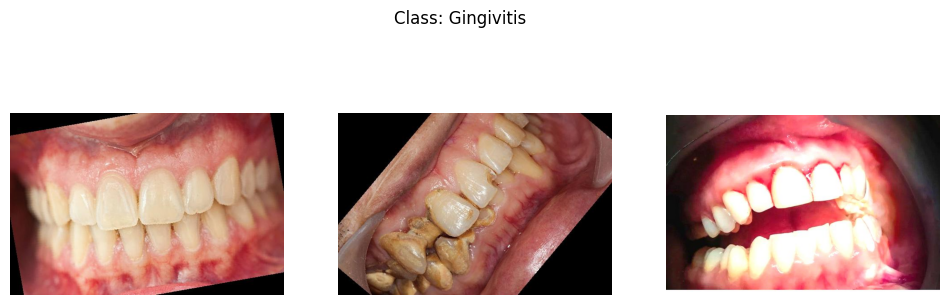

In [ ]:
# Visualize sample images
classes = os.listdir(dataset_path)

for cls in classes:
    folder_path = os.path.join(dataset_path, cls)
    sample_images = random.sample(os.listdir(folder_path), 3)

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Class: {cls}")

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()


                     Image Count
Hypodontia                  1251
Ulcers                      2540
Tooth_discoloration         1822
Healthy                     2275
Calculus                    1296
Caries                      2411
Gingivitis                  2359


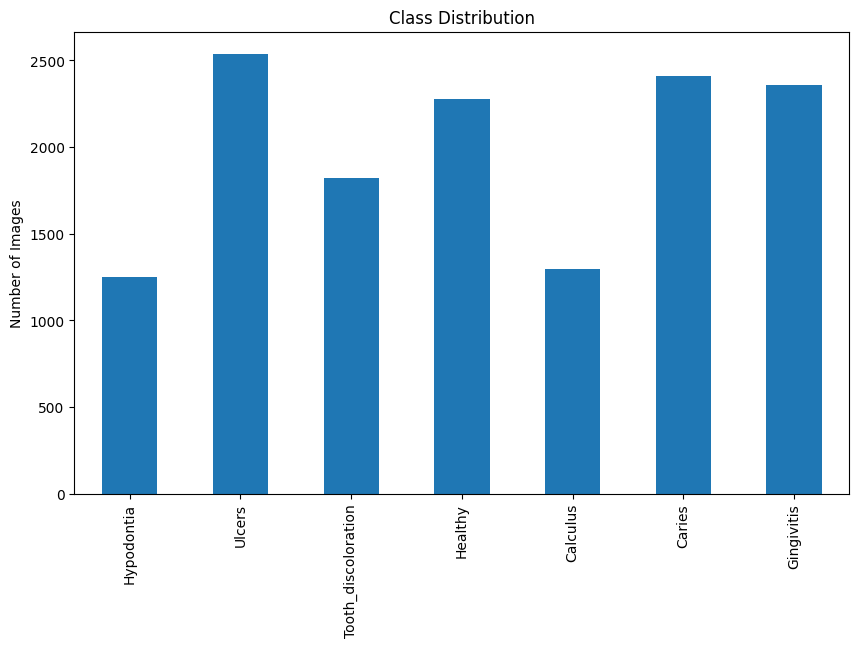

In [ ]:
# Analyze Class Balance

class_counts = {}

for cls in classes:
    folder_path = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(folder_path))
    class_counts[cls] = num_images

df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
print(df)

# Optional: Plot
df.plot(kind='bar', legend=False, figsize=(10, 6), title='Class Distribution')
plt.ylabel('Number of Images')
plt.show()


# 2. Preprocessing Pipeline

In [ ]:
# Define parameters
img_size = (224, 224)
batch_size = 32
seed = 123

# Load datasets (automatically splits)
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Further split validation into val/test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print(f"Train batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Val batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds)}")


Found 13954 files belonging to 7 classes.
Using 9768 files for training.
Found 13954 files belonging to 7 classes.
Using 4186 files for validation.
Train batches: 306
Val batches: 66
Test batches: 65


In [ ]:
# Apply data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])

# Apply to train dataset
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .shuffle(1000)
    .map(lambda x, y: (data_augmentation(x, training=True), y))
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

# 3. Model training & Evaluation

## i. MobileNetV2

In [ ]:
# ✅ Step 1: Load MobileNetV2 base
input_shape = (224, 224, 3)
num_classes = 7

base_model = applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = True # Freeze base initially

# ✅ Step 2: Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# ✅ Step 3: Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Step 4: Set callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    "MobileNetV2_best.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

earlystop_cb = callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

# ✅ Step 5: Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3019 - loss: 1.8304

306/306 ━━━━━━━━━━━━━━━━━━━━ 74s 103ms/step - accuracy: 0.3023 - loss: 1.8295 - val_accuracy: 0.4381 - val_loss: 1.5503
Epoch 2/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6742 - loss: 0.9459

306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6744 - loss: 0.9455 - val_accuracy: 0.6496 - val_loss: 0.9384
Epoch 3/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7758 - loss: 0.6532

306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7758 - loss: 0.6531 - val_accuracy: 0.7681 - val_loss: 0.6448
Epoch 4/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8335 - loss: 0.4891

306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8335 - loss: 0.4890 - val_accuracy: 0.8094 - val_loss: 0.5084
Epoch 5/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8713 - loss: 0.3860

306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8713 - loss: 0.3859 - val_accuracy: 0.8284 - val_loss: 0.4405
Epoch 6/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9007 - loss: 0.3049

306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9007 - loss: 0.3048 - val_accuracy: 0.8388 - val_loss: 0.3994
Epoch 7/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9246 - loss: 0.2416

306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9246 - loss: 0.2416 - val_accuracy: 0.8473 - val_loss: 0.3769
Epoch 8/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9446 - loss: 0.1959

306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9446 - loss: 0.1959 - val_accuracy: 0.8521 - val_loss: 0.3688
Epoch 9/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9593 - loss: 0.1579 - val_accuracy: 0.8506 - val_loss: 0.3617
Epoch 10/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9744 - loss: 0.1214 - val_accuracy: 0.8497 - val_loss: 0.3692
Epoch 11/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9837 - loss: 0.0940 - val_accuracy: 0.8521 - val_loss: 0.3688
Epoch 12/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9875 - loss: 0.0779

306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9875 - loss: 0.0779 - val_accuracy: 0.8525 - val_loss: 0.3701


In [ ]:
# Load best saved model
model.load_weights("MobileNetV2_best.h5")


# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8585 - loss: 0.3593
✅ Test Accuracy: 0.8548


In [ ]:
# Rebuild test dataset (to recover class names)
test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Capture class names BEFORE skipping
class_names = test_ds_raw.class_names
print("✅ Class names:", class_names)

Found 13966 files belonging to 7 classes.
Using 4189 files for validation.
✅ Class names: ['Calculus', 'Caries', 'Gingivitis', 'Healthy', 'Hypodontia', 'Tooth_discoloration', 'Ulcers']


In [ ]:
# Apply skip to carve out test set
val_batches = tf.data.experimental.cardinality(test_ds_raw)
test_ds_rebuilt = test_ds_raw.skip(val_batches // 2)

# Collect true labels + predictions
y_true = np.concatenate([y for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


Classification Report:
                      precision    recall  f1-score   support

           Calculus       0.58      0.68      0.62       198
             Caries       0.94      0.74      0.83       321
         Gingivitis       0.79      0.73      0.76       376
            Healthy       0.97      1.00      0.98       361
         Hypodontia       0.86      0.93      0.90       178
Tooth_discoloration       0.79      0.91      0.85       267
             Ulcers       0.97      0.95      0.96       379

           accuracy                           0.85      2080
          macro avg       0.84      0.85      0.84      2080
       weighted avg       0.86      0.85      0.86      2080



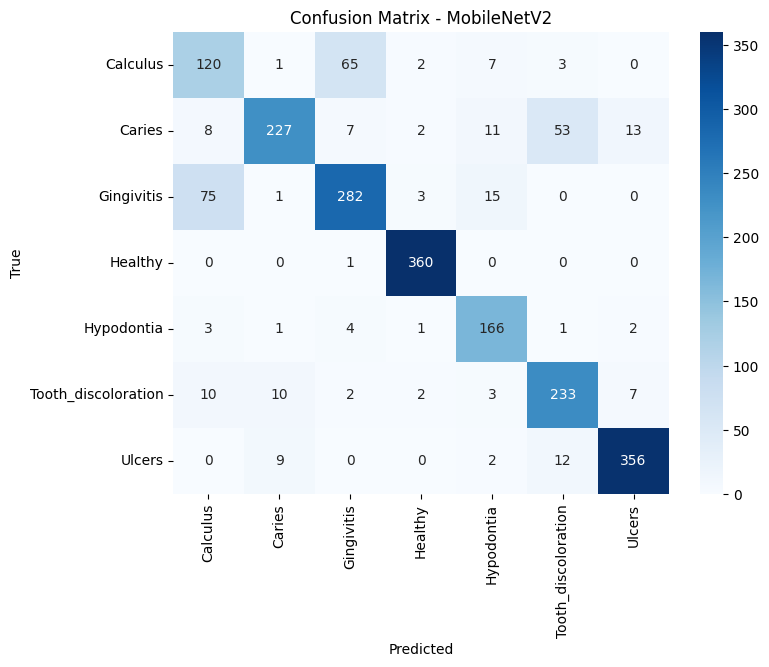

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

## ii. EfficientNetB0

In [ ]:
# ✅ Load EfficientNetB0 base
input_shape = (224, 224, 3)
num_classes = 7

base_model = applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = True

# ✅ Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# ✅ Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    "EfficientNetB0_best.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

earlystop_cb = callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

# ✅ Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.2103 - loss: 1.9404

306/306 ━━━━━━━━━━━━━━━━━━━━ 140s 255ms/step - accuracy: 0.2105 - loss: 1.9400 - val_accuracy: 0.5527 - val_loss: 1.4691
Epoch 2/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5350 - loss: 1.4262

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.5352 - loss: 1.4259 - val_accuracy: 0.7113 - val_loss: 1.0646
Epoch 3/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6974 - loss: 1.0255

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.6974 - loss: 1.0253 - val_accuracy: 0.7778 - val_loss: 0.7769
Epoch 4/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7716 - loss: 0.7555

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.7716 - loss: 0.7554 - val_accuracy: 0.8148 - val_loss: 0.6111
Epoch 5/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8056 - loss: 0.5970

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.8056 - loss: 0.5969 - val_accuracy: 0.8333 - val_loss: 0.5071
Epoch 6/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8379 - loss: 0.4945

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.8379 - loss: 0.4944 - val_accuracy: 0.8476 - val_loss: 0.4383
Epoch 7/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8526 - loss: 0.4276

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.8526 - loss: 0.4275 - val_accuracy: 0.8585 - val_loss: 0.3865
Epoch 8/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8741 - loss: 0.3691

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.8741 - loss: 0.3690 - val_accuracy: 0.8656 - val_loss: 0.3488
Epoch 9/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8855 - loss: 0.3247

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.8855 - loss: 0.3247 - val_accuracy: 0.8742 - val_loss: 0.3196
Epoch 10/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9013 - loss: 0.2852

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.9013 - loss: 0.2852 - val_accuracy: 0.8808 - val_loss: 0.2924
Epoch 11/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9156 - loss: 0.2534

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.9156 - loss: 0.2534 - val_accuracy: 0.8875 - val_loss: 0.2747
Epoch 12/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9198 - loss: 0.2294

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.9198 - loss: 0.2294 - val_accuracy: 0.8922 - val_loss: 0.2562
Epoch 13/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9337 - loss: 0.2010

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.9337 - loss: 0.2010 - val_accuracy: 0.8979 - val_loss: 0.2466
Epoch 14/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9411 - loss: 0.1810

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.9411 - loss: 0.1810 - val_accuracy: 0.8998 - val_loss: 0.2357
Epoch 15/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9464 - loss: 0.1671

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.9464 - loss: 0.1670 - val_accuracy: 0.9008 - val_loss: 0.2269
Epoch 16/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9482 - loss: 0.1546

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.9482 - loss: 0.1546 - val_accuracy: 0.9022 - val_loss: 0.2202
Epoch 17/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9553 - loss: 0.1376

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.9553 - loss: 0.1376 - val_accuracy: 0.9031 - val_loss: 0.2189
Epoch 18/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9581 - loss: 0.1245

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.9581 - loss: 0.1244 - val_accuracy: 0.9036 - val_loss: 0.2133
Epoch 19/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9636 - loss: 0.1127

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.9636 - loss: 0.1127 - val_accuracy: 0.9065 - val_loss: 0.2099
Epoch 20/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9653 - loss: 0.1024

306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.9653 - loss: 0.1024 - val_accuracy: 0.9093 - val_loss: 0.2073
Epoch 21/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.9732 - loss: 0.0893 - val_accuracy: 0.9074 - val_loss: 0.2159
Epoch 22/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.9774 - loss: 0.0822 - val_accuracy: 0.9065 - val_loss: 0.2155
Epoch 23/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.9801 - loss: 0.0714 - val_accuracy: 0.9084 - val_loss: 0.2196


In [ ]:
# Load best saved model
model.load_weights("EfficientNetB0_best.h5")


# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9162 - loss: 0.2132
✅ Test Accuracy: 0.9111


In [ ]:
# Rebuild test dataset (to recover class names)
test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Capture class names BEFORE skipping
class_names = test_ds_raw.class_names
print("✅ Class names:", class_names)

Found 13954 files belonging to 7 classes.
Using 4186 files for validation.
✅ Class names: ['Calculus', 'Caries', 'Gingivitis', 'Healthy', 'Hypodontia', 'Tooth_discoloration', 'Ulcers']


In [ ]:
# Apply skip to carve out test set
val_batches = tf.data.experimental.cardinality(test_ds_raw)
test_ds_rebuilt = test_ds_raw.skip(val_batches // 2)

# Collect true labels + predictions
y_true = np.concatenate([y for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
                      precision    recall  f1-score   support

           Calculus       0.64      0.71      0.67       197
             Caries       0.98      0.90      0.94       315
         Gingivitis       0.81      0.82      0.81       379
            Healthy       1.00      0.98      0.99       357
         Hypodontia       0.96      0.96      0.96       179
Tooth_discoloration       0.93      0.97      0.95       262
             Ulcers       1.00      1.00      1.00       391

           accuracy                           0.91      2080
          macro avg       0.90      0.90      0.90      2080
       weighted avg       0.92      0.91      0.91      2080



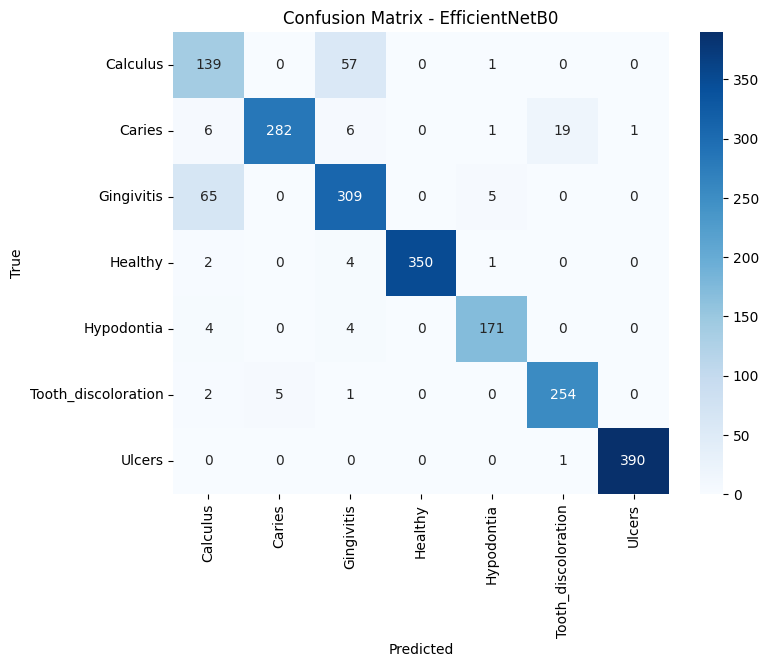

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - EfficientNetB0')
plt.show()

### Convert to Tflite model

In [ ]:
import tensorflow as tf

# Load model + weights
model.load_weights("EfficientNetB0_best.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable float16 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the TFLite model
with open('efficientnetb0_finetuned.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ TFLite model saved as efficientnetb0_finetuned.tflite")



Saved artifact at '/tmp/tmpm9gekbny'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1504')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136632004543120: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136632004542736: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136638721434704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638721434320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638721433360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638721434128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638721437200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638721432400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638721432784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638721431440: TensorSpec(shape=(), dtype=tf.resource, name

## iii. ResNet50

In [ ]:
# ✅ Load ResNet50 base
input_shape = (224, 224, 3)
num_classes = 7

base_model = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

# ✅ Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# ✅ Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    "ResNet50_best.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

earlystop_cb = callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

# ✅ Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/30
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2543 - loss: 2.1294

306/306 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.2553 - loss: 2.1261 - val_accuracy: 0.6188 - val_loss: 1.0562
Epoch 2/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5530 - loss: 1.2338

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5531 - loss: 1.2334 - val_accuracy: 0.7037 - val_loss: 0.7935
Epoch 3/30
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6278 - loss: 0.9883

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6279 - loss: 0.9880 - val_accuracy: 0.7373 - val_loss: 0.6866
Epoch 4/30
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6704 - loss: 0.8666

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6705 - loss: 0.8664 - val_accuracy: 0.7629 - val_loss: 0.6249
Epoch 5/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7147 - loss: 0.7710

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7147 - loss: 0.7709 - val_accuracy: 0.7752 - val_loss: 0.5792
Epoch 6/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7288 - loss: 0.7248

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7288 - loss: 0.7247 - val_accuracy: 0.7885 - val_loss: 0.5445
Epoch 7/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7547 - loss: 0.6707

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7546 - loss: 0.6707 - val_accuracy: 0.7990 - val_loss: 0.5195
Epoch 8/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7578 - loss: 0.6347

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7578 - loss: 0.6347 - val_accuracy: 0.8061 - val_loss: 0.5066
Epoch 9/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7722 - loss: 0.6076

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7722 - loss: 0.6076 - val_accuracy: 0.8146 - val_loss: 0.4853
Epoch 10/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7834 - loss: 0.5793

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7835 - loss: 0.5793 - val_accuracy: 0.8203 - val_loss: 0.4681
Epoch 11/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7894 - loss: 0.5581

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7894 - loss: 0.5581 - val_accuracy: 0.8250 - val_loss: 0.4609
Epoch 12/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7972 - loss: 0.5404

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7972 - loss: 0.5404 - val_accuracy: 0.8255 - val_loss: 0.4517
Epoch 13/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8025 - loss: 0.5222

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8025 - loss: 0.5222 - val_accuracy: 0.8317 - val_loss: 0.4396
Epoch 14/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8038 - loss: 0.5132

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8038 - loss: 0.5132 - val_accuracy: 0.8369 - val_loss: 0.4310
Epoch 15/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8114 - loss: 0.4951 - val_accuracy: 0.8359 - val_loss: 0.4301
Epoch 16/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8193 - loss: 0.4828

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8194 - loss: 0.4828 - val_accuracy: 0.8407 - val_loss: 0.4195
Epoch 17/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8217 - loss: 0.4667 - val_accuracy: 0.8355 - val_loss: 0.4126
Epoch 18/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8270 - loss: 0.4586 - val_accuracy: 0.8402 - val_loss: 0.4073
Epoch 19/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8201 - loss: 0.4583

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8202 - loss: 0.4582 - val_accuracy: 0.8497 - val_loss: 0.3979
Epoch 20/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8290 - loss: 0.4410 - val_accuracy: 0.8421 - val_loss: 0.4012
Epoch 21/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8370 - loss: 0.4342 - val_accuracy: 0.8450 - val_loss: 0.3939
Epoch 22/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8398 - loss: 0.4241 - val_accuracy: 0.8497 - val_loss: 0.3858
Epoch 23/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8458 - loss: 0.4105 - val_accuracy: 0.8487 - val_loss: 0.3898
Epoch 24/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8455 - loss: 0.4085

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8455 - loss: 0.4085 - val_accuracy: 0.8535 - val_loss: 0.3784
Epoch 25/30
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8456 - loss: 0.4102

306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8456 - loss: 0.4102 - val_accuracy: 0.8544 - val_loss: 0.3772
Epoch 26/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8464 - loss: 0.3983 - val_accuracy: 0.8464 - val_loss: 0.3814
Epoch 27/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8525 - loss: 0.3991 - val_accuracy: 0.8530 - val_loss: 0.3739
Epoch 28/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8560 - loss: 0.3820 - val_accuracy: 0.8511 - val_loss: 0.3725
Epoch 29/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8532 - loss: 0.3898 - val_accuracy: 0.8478 - val_loss: 0.3749
Epoch 30/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8536 - loss: 0.3855 - val_accuracy: 0.8506 - val_loss: 0.3684


In [ ]:
# Load best saved model
model.load_weights("ResNet50_best.h5")


# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8502 - loss: 0.3449
✅ Test Accuracy: 0.8587


In [ ]:
# Rebuild test dataset (to recover class names)
test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Capture class names BEFORE skipping
class_names = test_ds_raw.class_names
print("✅ Class names:", class_names)

Found 13966 files belonging to 7 classes.
Using 4189 files for validation.
✅ Class names: ['Calculus', 'Caries', 'Gingivitis', 'Healthy', 'Hypodontia', 'Tooth_discoloration', 'Ulcers']


In [ ]:
# Apply skip to carve out test set
val_batches = tf.data.experimental.cardinality(test_ds_raw)
test_ds_rebuilt = test_ds_raw.skip(val_batches // 2)

# Collect true labels + predictions
y_true = np.concatenate([y for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
                      precision    recall  f1-score   support

           Calculus       0.58      0.69      0.63       198
             Caries       0.89      0.79      0.84       321
         Gingivitis       0.80      0.74      0.77       376
            Healthy       0.99      0.98      0.99       361
         Hypodontia       0.94      0.92      0.93       178
Tooth_discoloration       0.82      0.92      0.87       267
             Ulcers       0.93      0.93      0.93       379

           accuracy                           0.86      2080
          macro avg       0.85      0.85      0.85      2080
       weighted avg       0.86      0.86      0.86      2080



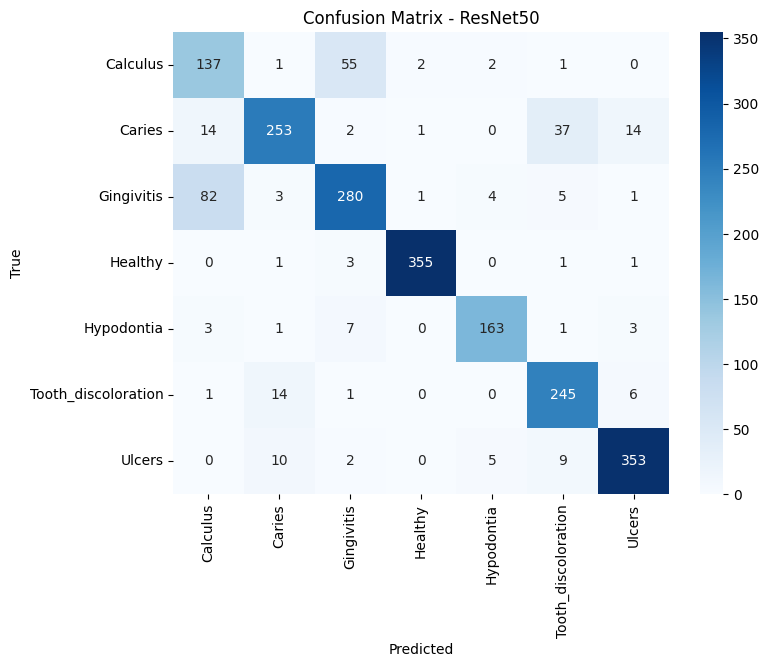

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
plt.show()

## iv. DenseNet121

In [ ]:
# ✅ Load DenseNet121 base
input_shape = (224, 224, 3)
num_classes = 7

base_model = applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

# ✅ Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# ✅ Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    "DenseNet121_best.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

earlystop_cb = callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

# ✅ Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1495 - loss: 7.2883

306/306 ━━━━━━━━━━━━━━━━━━━━ 69s 144ms/step - accuracy: 0.1496 - loss: 7.2849 - val_accuracy: 0.2698 - val_loss: 2.6588
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2072 - loss: 4.7830

306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.2072 - loss: 4.7824 - val_accuracy: 0.3343 - val_loss: 2.2263
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2613 - loss: 3.9208

306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2613 - loss: 3.9205 - val_accuracy: 0.3940 - val_loss: 1.9393
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2893 - loss: 3.4011

306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.2893 - loss: 3.4008 - val_accuracy: 0.4320 - val_loss: 1.7924
Epoch 5/10
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3213 - loss: 2.9959

306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.3213 - loss: 2.9959 - val_accuracy: 0.4689 - val_loss: 1.6702
Epoch 6/10
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3435 - loss: 2.6031

306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3435 - loss: 2.6029 - val_accuracy: 0.4898 - val_loss: 1.5493
Epoch 7/10
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3708 - loss: 2.3669

306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.3707 - loss: 2.3668 - val_accuracy: 0.5211 - val_loss: 1.4239
Epoch 8/10
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4016 - loss: 2.1370

306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.4016 - loss: 2.1370 - val_accuracy: 0.5277 - val_loss: 1.3681
Epoch 9/10
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4139 - loss: 2.0003

306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.4138 - loss: 2.0003 - val_accuracy: 0.5514 - val_loss: 1.3055
Epoch 10/10
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4385 - loss: 1.8424

306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.4384 - loss: 1.8425 - val_accuracy: 0.5529 - val_loss: 1.2805


In [ ]:
# Load best saved model
model.load_weights("DenseNet121_best.h5")


# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5568 - loss: 1.2217
✅ Test Accuracy: 0.5462


In [ ]:
# Rebuild test dataset (to recover class names)
test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Capture class names BEFORE skipping
class_names = test_ds_raw.class_names
print("✅ Class names:", class_names)

Found 13966 files belonging to 7 classes.
Using 4189 files for validation.
✅ Class names: ['Calculus', 'Caries', 'Gingivitis', 'Healthy', 'Hypodontia', 'Tooth_discoloration', 'Ulcers']


In [ ]:
# Apply skip to carve out test set
val_batches = tf.data.experimental.cardinality(test_ds_raw)
test_ds_rebuilt = test_ds_raw.skip(val_batches // 2)

# Collect true labels + predictions
y_true = np.concatenate([y for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step


In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
                      precision    recall  f1-score   support

           Calculus       0.38      0.30      0.34       198
             Caries       0.44      0.29      0.35       321
         Gingivitis       0.65      0.54      0.59       376
            Healthy       0.75      0.85      0.79       361
         Hypodontia       0.83      0.31      0.45       178
Tooth_discoloration       0.32      0.66      0.43       267
             Ulcers       0.64      0.64      0.64       379

           accuracy                           0.55      2080
          macro avg       0.57      0.51      0.51      2080
       weighted avg       0.58      0.55      0.54      2080



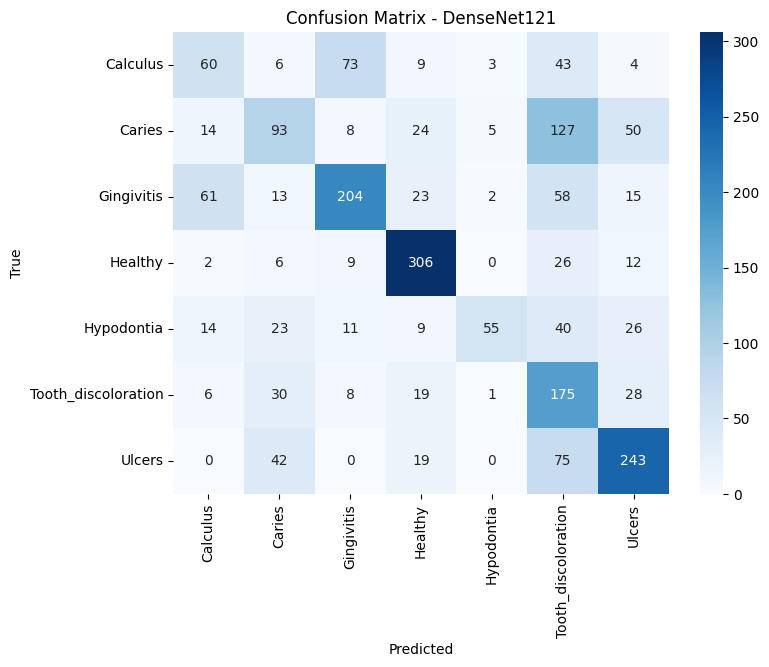

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - DenseNet121')
plt.show()

# Sample Prediction

Found 13954 files belonging to 7 classes.
Using 4186 files for validation.
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


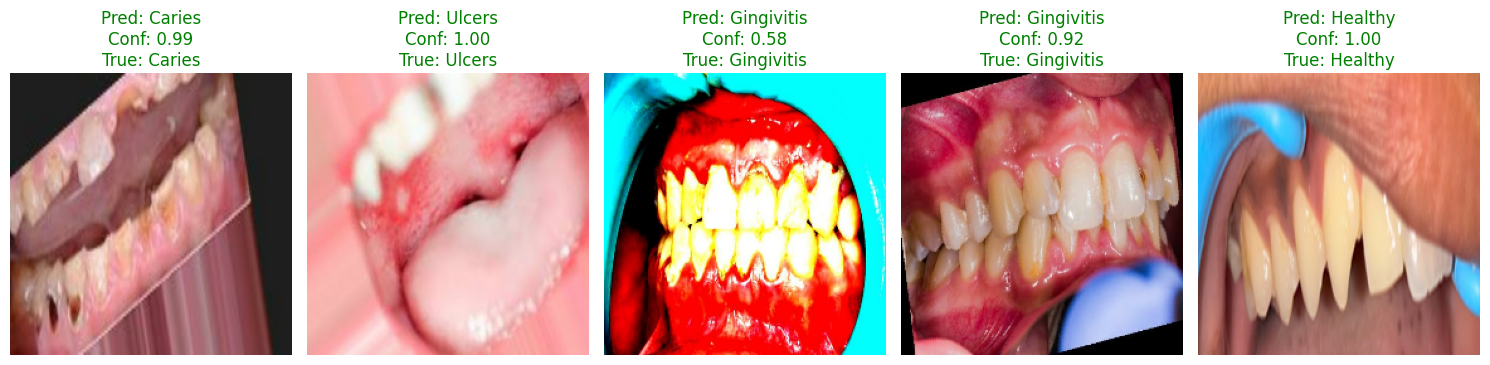

In [ ]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt

# Load fine-tuned EfficientNetB0 model
model.load_weights("EfficientNetB0_best.h5")

# Rebuild dataset to get class names
raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)
class_names = raw_test_ds.class_names

# Collect all test images + labels
x_test = np.concatenate([x for x, y in test_ds], axis=0)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Predict probabilities
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Randomly pick samples
num_samples = 5
indices = random.sample(range(len(x_test)), num_samples)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(indices):
    img = x_test[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    confidence = np.max(y_pred_probs[idx])

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img.astype('uint8'))
    if true_label == pred_label:
        title_color = 'green'
    else:
        title_color = 'red'
    plt.title(f"Pred: {pred_label}\nConf: {confidence:.2f}\nTrue: {true_label}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Prediction on sample pilot data

Saving (9).jpg to (9).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


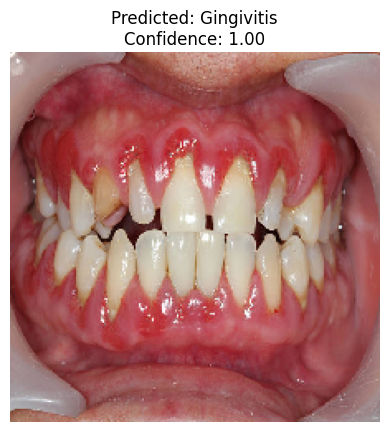

✅ (9).jpg → Predicted: Gingivitis (Confidence: 1.00)


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load model weights
model.load_weights("EfficientNetB0_best.h5")

# Upload images manually
uploaded = files.upload()

for filename in uploaded.keys():
    # Load and preprocess image
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    pred_index = np.argmax(predictions[0])
    pred_class = class_names[pred_index]
    confidence = predictions[0][pred_index]

    # Display image + prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}")
    plt.show()

    print(f"✅ {filename} → Predicted: {pred_class} (Confidence: {confidence:.2f})")
